# Goes through all simulations and print statistics

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mtplc
import pandas as pd
import numpy as np
import tomli
import tqdm
import pickle, gzip
import seaborn as sns

from qutip import Qobj
import qutip as qt

from pathlib import Path

ROOT = Path('simulations')


OBSERVABLES = [
    "energy"
]
VARIABLE_COLUMNS = [
    ("phaseonium", "phi_hot"),
    ("phaseonium", "phi_cold"),
    ("cavity1", "expanding_force"),
    ("cavity1", "compressing_force"),
    ("cavity2", "expanding_force"),
    ("cavity2", "compressing_force"),
    ("stroke_time", "isochore"),
]
OMEGA = 5.0
T_HOT = 2.5
T_COLD = 1.0

REGENERATE = True

# Colors for the strokes
CS1 = "#454545"
CS2 = "#888888"

ledger = pd.read_csv(ROOT / 'simulations_ledger.csv', header=[0, 1])
ledger["Error"] = [0 for _ in range(len(ledger))]
ledger.set_index(("meta", "name"), inplace=True)
print(f"There are {len(ledger)} simulations in the ledger")

There are 1243 simulations in the ledger


In [4]:
def assign_forces(config, strokes, sampling_times):
    f1_exp = config["cavity1"]["expanding_force"]
    f1_comp = config["cavity1"]["compressing_force"]
    f2_exp = config["cavity2"]["expanding_force"]
    f2_comp = config["cavity2"]["compressing_force"]
    forces1 = []
    forces2 = []
    for t in sampling_times:
        if t < strokes[0][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[1][1]:
            forces1.append(f1_exp)
            forces2.append(f2_exp)
        elif t < strokes[2][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[3][1]:
            forces1.append(f1_comp)
            forces2.append(f2_comp)
        else:
            forces1.append(0)
            forces2.append(0)

    return np.array(forces1), np.array(forces2)


def read_configuration(filepath, system_evolution_times):

    with open(filepath / "config.toml", "rb") as config_file:
            config = tomli.load(config_file)

    ndims = int(config["meta"]["dims"])
    dt = config["meta"]["dt"]
    alpha = config["cavity1"]["alpha"]
    surfaces = (config["cavity1"]["surface"], config["cavity2"]["surface"])

    isochore_steps = config["stroke_time"]["isochore"]
    isochore_samplings = config["samplings"]["isochore"]
    adiabatic_samplings = config["samplings"]["adiabatic"]

    cycle_steps = np.cumsum(np.load(filepath / "cycle_steps.npy"))  # Duration of each step
    strokes = [
        (0, cycle_steps[0]),
        (cycle_steps[0] + dt, cycle_steps[1]),
        (cycle_steps[1] + dt, cycle_steps[2]),
        (cycle_steps[2] + dt, cycle_steps[3]),
    ]
    
    samplings = sorted(system_evolution_times, key=lambda x: int(x))

    # Take the left-hand side of each interval
    sampling_times = np.array([
        *np.linspace(*strokes[0], isochore_samplings),
        *np.linspace(*strokes[1], adiabatic_samplings),
        *np.linspace(*strokes[2], isochore_samplings),
        *np.linspace(*strokes[3], adiabatic_samplings)
    ]).flatten()

    forces = assign_forces(config, strokes, sampling_times)
    sampling_times_dict = {v: int(k) for k, v in zip(samplings, sampling_times)}

    return ndims, alpha, surfaces, forces, sampling_times, strokes


def create_evolution_dict():
    dict = {
        "S":{
            "State": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Mutual Information": [],
            "Work": {
                "Alicki": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S1": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S2": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
    }
    return dict


def avg_energy(s:Qobj, h:Qobj) -> float:
    return (s * h).tr()


## Work and Heat

In [5]:
# Calculate work and heat by Alicki's definition
def alicki_definition(rho, rho_previous, h, h_previous):
    if rho_previous is None:
        return (0, 0)
    
    # Energy changes between steps
    energy = (rho * h).tr()
    energy_previous = (rho_previous * h_previous).tr()
    delta_energy = energy - energy_previous
    
    # Calculate adiabatic energy changes (work)
    # This requires calculating energy expectation of previous density matrix with current Hamiltonian
    adiabatic_energy = (rho_previous * h).tr()
    work = np.real(adiabatic_energy - energy_previous)

    # Heat is the remaining energy change
    heat = np.real(delta_energy - work)
    
    return work, heat


def calc_pressure_op(ndims, alpha, l, s, t):
    idd = Qobj(np.diag(np.ones(ndims)))  # Identity matrix
    n = Qobj(np.diag(np.arange(1, ndims + 1)))
    a = qt.destroy(ndims)
    ad = a.dag()

    f = alpha / l

    pressure_op = (2*n + idd)
    pressure_op -= (a * a * np.exp(-1j*2*f*t)) 
    pressure_op -= (ad * ad * np.exp(1j*2*f*t))

    return alpha / (2 * l**2 * s) * pressure_op


def pressure_work(rho, rho_previous, l, l_previous, t, ndims, alpha, s):
    if rho_previous is None:
        return (0, 0)
    
    delta_l = l - l_previous
    
    pressure_op = calc_pressure_op(ndims, alpha, l, s, t)

    pressure = qt.expect(pressure_op, rho)

    work = pressure * s * delta_l

    return work


# Compute work via the external force applied to the moving mirror
def classical_work(force, l, l_previous):
    # Calculate the movement of the cavity
    delta_l = l - l_previous

    work = force * delta_l

    return work



## Plot Functions

In [6]:
def plot_observable(x, y, stroke_times=None, ymin=None, ymax=None, label=None, ax=None, title=None, grid=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(title)

        if grid:
            ax.grid(linestyle="--", alpha=0.2)
        
        if not ymin:
            ymin = min(y) - 0.2*min(y) if min(y) > 0 else min(y) + 0.2*min(y)
        ymax = max(y) + 0.2*max(y) if not ymax else ymax
        plot_stroke_overlays(ax, ymin, ymax, stroke_times)
        return_obj = (fig, ax)
    else:
        ax.set_title(title)
        return_obj = None
        
    ax.plot(x, y, label=label)
    if label:
        ax.legend()
        
    return return_obj


def plot_stroke_overlays(ax, ymin, ymax, stroke_times):
    ax.fill_betweenx([ymin, ymax], *stroke_times[0], alpha=0.1, fc='r')
    ax.fill_betweenx([ymin, ymax], *stroke_times[2], alpha=0.1, fc='b')


def plot_evolution(name, observables, sampling_times, stroke_times, show=False, filepath=None):
    if name == "Entropy":
        ys = [
            observables["S"]["Entropy"],
            observables["S1"]["Entropy"],
            observables["S2"]["Entropy"],
        ]
        label = "S"
    elif name == "Mutual Information":
        ys = [
            observables["S"]["Mutual Information"]
        ]
        label = "I"
    elif name == "Alicki's Work":
        ys = [
            observables["S"]["Work"]["Alicki"],
            observables["S1"]["Work"]["Alicki"],
            observables["S2"]["Work"]["Alicki"],
        ]
        label = "W"
    elif name == "Heat":
        ys = [
            observables["S"]["Heat"],
            observables["S1"]["Heat"],
            observables["S2"]["Heat"],
        ]
        label = "Q"
    else:
        raise ValueError(f"Observable {name} not known.")

    fig, ax = plot_observable(sampling_times, ys[0], stroke_times=stroke_times, label=f"{label}AB")
    if len(ys) > 1:
        for y, s in zip(ys, ['A', 'B']):
            plot_observable(sampling_times, y, label=f"{label}{s}", ax=ax)

    ax.set_title(name)

    if filepath is not None:
        filename = name.lower().replace("'", "").replace(" ", "_")
        fig.savefig(filepath / f"visualization/{filename}.png")
        fig.savefig(filepath / f"visualization/{filename}.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None


def plot_f_E_cycle(ax, frequencies, energies):
    f1, f2 = frequencies
    energy1, energy2 = energies
    ax.plot(f1, energy1, label="$S1$", c=CS1)
    ax.plot(f2, energy2, label="$S2$", c=CS2, ls="--")
    ax.text(0.495, 0.49, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS2,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    ax.text(0.505, 0.51, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS1,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    
    # Create the strokes overlays
    ymax = max(max(energy1), max(energy2)) + 0.1*max(max(energy1), max(energy2))
    ymin = min(min(energy1), min(energy2)) - 0.1*min(min(energy1), min(energy2))
    # Heating stroke at maximum frequency
    x_heating = max(max(f1), max(f2))
    dx_h = 0.0001 * x_heating
    # Cooling stroke at minimum frequency
    x_cooling = min(min(f1), min(f2))
    dx_c = 0.0001 * x_cooling
    ax.fill_between([x_cooling - dx_c, x_cooling + dx_c], ymin, ymax, alpha=0.2, fc='b', label="Cooling")
    ax.fill_between([x_heating - dx_h, x_heating + dx_h], ymin, ymax, alpha=0.2, fc='r', label="Heating")


def plot_obs_evolution(ax, observables, name, sampling_times, stroke_times):
    y1, y2 = observables
    ax.set_title(name)
    ax.plot(sampling_times, y1, c=CS1)
    ax.plot(sampling_times, y2, c=CS2, ls="--")
    ax.fill_between(stroke_times[0], min(y1), max(y1), alpha=0.1, fc='r')
    ax.fill_between(stroke_times[2], min(y1), max(y1), alpha=0.1, fc='b')
    

def plot_cycles(observables, sampling_times, stroke_times, ax=None, show=True, filepath=None):
    f1 = observables["S1"]["Frequency"]
    f2 = observables["S2"]["Frequency"]
    energy1 = observables["S1"]["Energy"]
    energy2 = observables["S2"]["Energy"]
    
    if ax is not None:
        plot_f_E_cycle(ax, (f1, f2), (energy1, energy2))    
        ax.grid(alpha=0.2, linestyle='--')  
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(3, layout="constrained", figsize=(8, 10))
        fig.suptitle("Cavities Cycles")
        plot_f_E_cycle(ax1, (f1, f2), (energy1, energy2))
        plot_obs_evolution(ax2, (f1, f2), "Frequencies", sampling_times, stroke_times)
        plot_obs_evolution(ax3, (energy1, energy2), "Energies", sampling_times, stroke_times)

        # Place the legend on top of the figure
        fig.legend(bbox_to_anchor=(0., 1., 1.05, 0.04), loc=2, ncol=4, mode="expand")
        # Add the grids
        for ax in (ax1, ax2, ax3):
            ax.grid(alpha=0.2, linestyle='--')  

    if filepath is not None:        
        fig.savefig(filepath / "visualization/cycle_dynamics.png")
        fig.savefig(filepath / "visualization/cycle_dynamics.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None



## Extract Good Simulations

In [7]:
def extract_simulation_data(file, plots=False):
        
    system_evolution = np.load(file / "cascade_evolution_1cycle.npz")
    cavities_evolution = np.load(file / "cavities_evolution_1cycle.npz")
    
    evolution_history = create_evolution_dict()
    ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(file, system_evolution.files)    # Evolution of the multipartite system in terms of Qobj
    surf1, surf2 = surfaces
    forces1, forces2 = forces
    print(len(forces1), end=', ')
    print(len(forces2), end=' - ')
    print(len(sampling_times))
    s_evolution = []
    rho_previous = rho1_previous = rho2_previous = None
    h_previous = h1_previous = h2_previous = None
    l1_previous = alpha / cavities_evolution["c1"][0]
    l2_previous = alpha / cavities_evolution["c2"][0]
    
    for i, t in enumerate(tqdm.tqdm(sampling_times, desc=f"Extracting data from {file.name}")):
        rho = Qobj(system_evolution[str(i + 1)], dims=[[ndims, ndims], [ndims, ndims]])
        s1:Qobj = rho.ptrace(1)
        s2:Qobj = rho.ptrace(0)
        evolution_history["S"]["State"].append(rho)
        evolution_history["S1"]["State"].append(s1)
        evolution_history["S2"]["State"].append(s2)

        f1:float = cavities_evolution["c1"][i]
        l1 = alpha / f1
        f2:float = cavities_evolution["c2"][i]
        l2 = alpha / f2
        evolution_history["S1"]["Frequency"].append(f1)
        evolution_history["S2"]["Frequency"].append(f2)

        # Hamiltonian
        h1 = Qobj(f1 * np.diag(np.arange(1, ndims + 1)))
        h2 = Qobj(f2 * np.diag(np.arange(1, ndims + 1)))
        h = qt.tensor(h1, h2)
        evolution_history["S"]["Hamiltonian"].append(h)
        evolution_history["S1"]["Hamiltonian"].append(h1)
        evolution_history["S2"]["Hamiltonian"].append(h2)
        
        # Observables
        evolution_history["S"]["Energy"].append(avg_energy(rho, h))
        evolution_history["S1"]["Energy"].append(avg_energy(s1, h1))
        evolution_history["S2"]["Energy"].append(avg_energy(s2, h2))
        evolution_history["S"]["Entropy"].append(qt.entropy_vn(rho))
        evolution_history["S1"]["Entropy"].append(qt.entropy_vn(s1))
        evolution_history["S2"]["Entropy"].append(qt.entropy_vn(s2))
        evolution_history["S"]["Mutual Information"].append(qt.entropy_mutual(rho, 0, 1))

        # Work and Heat
        alicki_work, alicki_heat = alicki_definition(rho, rho_previous, h, h_previous)
        alicki_work1, alicki_heat1 = alicki_definition(s1, rho1_previous, h1, h1_previous)
        alicki_work2, alicki_heat2 = alicki_definition(s2, rho2_previous, h2, h2_previous)
        evolution_history["S"]["Work"]["Alicki"].append(alicki_work)
        evolution_history["S"]["Heat"].append(alicki_heat)
        evolution_history["S1"]["Work"]["Alicki"].append(alicki_work1)
        evolution_history["S1"]["Work"]["Pressure"].append(pressure_work(s1, rho1_previous, l1, l1_previous, t, ndims, alpha, surf1))
        evolution_history["S1"]["Work"]["Classic"].append(classical_work(forces1[i], l1, l1_previous))
        evolution_history["S1"]["Heat"].append(alicki_heat1)
        evolution_history["S2"]["Work"]["Alicki"].append(alicki_work2)
        evolution_history["S2"]["Work"]["Pressure"].append(pressure_work(s2, rho2_previous, l2, l2_previous, t, ndims, alpha, surf2))
        evolution_history["S2"]["Work"]["Classic"].append(classical_work(forces2[i], l2, l2_previous))
        evolution_history["S2"]["Heat"].append(alicki_heat2)

        rho_previous, rho1_previous, rho2_previous = rho, s1, s2
        l1_previous, l2_previous = l1, l2
        h_previous, h1_previous, h2_previous = h, h1, h2
    
    with gzip.open(file / "evolution_history.pkl.gz", "wb") as zipfile:
        pickle.dump(evolution_history, zipfile)

    if plots:
        plot_cycles(evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Entropy", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Mutual Information", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Alicki's Work", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Heat", evolution_history, sampling_times, stroke_times, show=False, filepath=file)

In [14]:
ledger_filtered = ledger.loc[(ledger[("cavity1", "compressing_force")] == 2.0) & (ledger[("cavity2", "compressing_force")] == 2.0)]

In [15]:
simulation_folders = [ROOT / f"simulation_{n}" for n in ledger_filtered.index]
good_simulations = []
for f in simulation_folders:
    if not f.is_dir() or not (f / "cascade_evolution_1cycle.npz").exists():
        # Go to the next filename
        ledger.loc[f.name.replace("simulation_", ""), "Error"] = 1
        continue
    else:
        ledger.loc[f.name.replace("simulation_", ""), "Error"] = 0

    if REGENERATE:
        print(f"Extracting from {f.name}")
        try:
            extract_simulation_data(f, plots=True)
        except FileNotFoundError as e:
            print(f"Simulation {f.name} failed with error: {e}")
            continue
    if (f / "evolution_history.pkl.gz").exists():
        good_simulations.append(f.name)

print(f"There are a total of {len(good_simulations)} finished simulations.")

Extracting from simulation_1eb02d5b-e
300, 300 - 300


Extracting data from simulation_1eb02d5b-e: 100%|██████████| 300/300 [00:18<00:00, 16.53it/s]


Extracting from simulation_28e5ad9f-f
300, 300 - 300


Extracting data from simulation_28e5ad9f-f: 100%|██████████| 300/300 [00:19<00:00, 15.56it/s]


Extracting from simulation_9a6c83ff-f
300, 300 - 300


Extracting data from simulation_9a6c83ff-f: 100%|██████████| 300/300 [00:17<00:00, 16.92it/s]


Extracting from simulation_79c32921-5
300, 300 - 300


Extracting data from simulation_79c32921-5: 100%|██████████| 300/300 [00:21<00:00, 13.77it/s]


Extracting from simulation_e08d8fa5-1
300, 300 - 300


Extracting data from simulation_e08d8fa5-1: 100%|██████████| 300/300 [00:23<00:00, 12.67it/s]


Extracting from simulation_9f5b36a9-2
300, 300 - 300


Extracting data from simulation_9f5b36a9-2: 100%|██████████| 300/300 [00:21<00:00, 13.89it/s]


Extracting from simulation_7acb5aec-7
300, 300 - 300


Extracting data from simulation_7acb5aec-7: 100%|██████████| 300/300 [00:20<00:00, 14.57it/s]


Extracting from simulation_954d9cea-a
300, 300 - 300


Extracting data from simulation_954d9cea-a: 100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


Extracting from simulation_a69b9a57-1
300, 300 - 300


Extracting data from simulation_a69b9a57-1: 100%|██████████| 300/300 [00:21<00:00, 14.05it/s]


Extracting from simulation_c88d9704-1
300, 300 - 300


Extracting data from simulation_c88d9704-1: 100%|██████████| 300/300 [00:18<00:00, 16.39it/s]


Extracting from simulation_b57e534b-c
300, 300 - 300


Extracting data from simulation_b57e534b-c: 100%|██████████| 300/300 [00:17<00:00, 17.42it/s]


Extracting from simulation_e1f257d2-e
300, 300 - 300


Extracting data from simulation_e1f257d2-e: 100%|██████████| 300/300 [00:30<00:00,  9.90it/s]


Extracting from simulation_b2bf5f2c-1
300, 300 - 300


Extracting data from simulation_b2bf5f2c-1: 100%|██████████| 300/300 [00:20<00:00, 14.67it/s]


Extracting from simulation_3ddd6c74-f
300, 300 - 300


Extracting data from simulation_3ddd6c74-f: 100%|██████████| 300/300 [00:24<00:00, 12.22it/s]


Extracting from simulation_6c4a62c3-d
300, 300 - 300


Extracting data from simulation_6c4a62c3-d: 100%|██████████| 300/300 [00:15<00:00, 18.95it/s]


Extracting from simulation_4f1f1dad-7
300, 300 - 300


Extracting data from simulation_4f1f1dad-7: 100%|██████████| 300/300 [00:25<00:00, 11.66it/s]


Extracting from simulation_a8381e55-2
300, 300 - 300


Extracting data from simulation_a8381e55-2: 100%|██████████| 300/300 [00:16<00:00, 17.67it/s]


Extracting from simulation_a3bd6a8a-d
300, 300 - 300


Extracting data from simulation_a3bd6a8a-d: 100%|██████████| 300/300 [00:15<00:00, 19.04it/s]


Extracting from simulation_abcade03-8
300, 300 - 300


Extracting data from simulation_abcade03-8: 100%|██████████| 300/300 [00:17<00:00, 17.47it/s]


Extracting from simulation_8317f4f5-7
300, 300 - 300


Extracting data from simulation_8317f4f5-7: 100%|██████████| 300/300 [00:16<00:00, 18.33it/s]


Extracting from simulation_d0515f3d-c
300, 300 - 300


Extracting data from simulation_d0515f3d-c: 100%|██████████| 300/300 [00:19<00:00, 15.71it/s]


Extracting from simulation_199dd8a5-e
300, 300 - 300


Extracting data from simulation_199dd8a5-e: 100%|██████████| 300/300 [00:14<00:00, 21.25it/s]


Extracting from simulation_7f896454-3
300, 300 - 300


Extracting data from simulation_7f896454-3: 100%|██████████| 300/300 [00:21<00:00, 14.23it/s]


Extracting from simulation_5d39afaa-5
300, 300 - 300


Extracting data from simulation_5d39afaa-5: 100%|██████████| 300/300 [00:17<00:00, 17.12it/s]


Extracting from simulation_1f857557-7
300, 300 - 300


Extracting data from simulation_1f857557-7: 100%|██████████| 300/300 [00:16<00:00, 18.30it/s]


Extracting from simulation_7470908f-6
300, 300 - 300


Extracting data from simulation_7470908f-6: 100%|██████████| 300/300 [00:21<00:00, 13.79it/s]


Extracting from simulation_39637549-8
300, 300 - 300


Extracting data from simulation_39637549-8: 100%|██████████| 300/300 [00:27<00:00, 10.78it/s]


Extracting from simulation_121881ad-c
300, 300 - 300


Extracting data from simulation_121881ad-c: 100%|██████████| 300/300 [00:20<00:00, 14.54it/s]


Extracting from simulation_d0abab11-1
300, 300 - 300


Extracting data from simulation_d0abab11-1: 100%|██████████| 300/300 [00:26<00:00, 11.35it/s]


Extracting from simulation_f33263a1-4
300, 300 - 300


Extracting data from simulation_f33263a1-4: 100%|██████████| 300/300 [00:14<00:00, 21.37it/s]


Extracting from simulation_0b288d98-f
300, 300 - 300


Extracting data from simulation_0b288d98-f: 100%|██████████| 300/300 [00:17<00:00, 16.68it/s]


Extracting from simulation_2e7e99dc-4
300, 300 - 300


Extracting data from simulation_2e7e99dc-4: 100%|██████████| 300/300 [00:17<00:00, 17.18it/s]


Extracting from simulation_7aae8bbf-3
300, 300 - 300


Extracting data from simulation_7aae8bbf-3: 100%|██████████| 300/300 [00:16<00:00, 18.09it/s]


Extracting from simulation_d10c2728-c
300, 300 - 300


Extracting data from simulation_d10c2728-c: 100%|██████████| 300/300 [00:18<00:00, 16.42it/s]


Extracting from simulation_c9006398-8
300, 300 - 300


Extracting data from simulation_c9006398-8: 100%|██████████| 300/300 [00:18<00:00, 15.80it/s]


Extracting from simulation_b414e0d2-e
300, 300 - 300


Extracting data from simulation_b414e0d2-e: 100%|██████████| 300/300 [00:17<00:00, 16.72it/s]


Extracting from simulation_249b69c1-6
300, 300 - 300


Extracting data from simulation_249b69c1-6: 100%|██████████| 300/300 [00:22<00:00, 13.19it/s]


Extracting from simulation_da1cc813-8
300, 300 - 300


Extracting data from simulation_da1cc813-8: 100%|██████████| 300/300 [00:13<00:00, 22.55it/s]


Extracting from simulation_fd84a1ad-f
300, 300 - 300


Extracting data from simulation_fd84a1ad-f: 100%|██████████| 300/300 [00:13<00:00, 23.01it/s]


Extracting from simulation_e65b88b9-5
300, 300 - 300


Extracting data from simulation_e65b88b9-5: 100%|██████████| 300/300 [00:15<00:00, 19.81it/s]


Extracting from simulation_dec56aed-5
300, 300 - 300


Extracting data from simulation_dec56aed-5: 100%|██████████| 300/300 [00:17<00:00, 17.54it/s]


Extracting from simulation_6131a0b9-0
300, 300 - 300


Extracting data from simulation_6131a0b9-0: 100%|██████████| 300/300 [00:15<00:00, 19.41it/s]


Extracting from simulation_23a38cad-f
300, 300 - 300


Extracting data from simulation_23a38cad-f: 100%|██████████| 300/300 [00:17<00:00, 17.09it/s]


Extracting from simulation_23e8c1bb-a
300, 300 - 300


Extracting data from simulation_23e8c1bb-a: 100%|██████████| 300/300 [00:18<00:00, 16.03it/s]


Extracting from simulation_c7f98d7e-6
300, 300 - 300


Extracting data from simulation_c7f98d7e-6: 100%|██████████| 300/300 [00:26<00:00, 11.51it/s]


Extracting from simulation_31d2095c-5
300, 300 - 300


Extracting data from simulation_31d2095c-5: 100%|██████████| 300/300 [00:25<00:00, 11.58it/s]


Extracting from simulation_8f2a6e7e-7
300, 300 - 300


Extracting data from simulation_8f2a6e7e-7: 100%|██████████| 300/300 [00:26<00:00, 11.17it/s]


Extracting from simulation_b5b25531-c
300, 300 - 300


Extracting data from simulation_b5b25531-c: 100%|██████████| 300/300 [00:16<00:00, 18.52it/s]


Extracting from simulation_67e27ffc-5
300, 300 - 300


Extracting data from simulation_67e27ffc-5: 100%|██████████| 300/300 [00:35<00:00,  8.37it/s]


Extracting from simulation_4cf92c81-c
300, 300 - 300


Extracting data from simulation_4cf92c81-c: 100%|██████████| 300/300 [00:14<00:00, 20.22it/s]


Extracting from simulation_0dede544-5
300, 300 - 300


Extracting data from simulation_0dede544-5: 100%|██████████| 300/300 [00:17<00:00, 17.44it/s]


Extracting from simulation_797b4cb5-b
300, 300 - 300


Extracting data from simulation_797b4cb5-b: 100%|██████████| 300/300 [00:17<00:00, 16.85it/s]


Extracting from simulation_73610874-f
300, 300 - 300


Extracting data from simulation_73610874-f: 100%|██████████| 300/300 [00:16<00:00, 18.35it/s]


Extracting from simulation_7db36c13-d
300, 300 - 300


Extracting data from simulation_7db36c13-d: 100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


Extracting from simulation_5d458942-a
300, 300 - 300


Extracting data from simulation_5d458942-a: 100%|██████████| 300/300 [00:17<00:00, 17.46it/s]


Extracting from simulation_79fb3d07-3
300, 300 - 300


Extracting data from simulation_79fb3d07-3: 100%|██████████| 300/300 [00:16<00:00, 17.75it/s]


Extracting from simulation_b78c409d-3
300, 300 - 300


Extracting data from simulation_b78c409d-3: 100%|██████████| 300/300 [00:20<00:00, 14.92it/s]


Extracting from simulation_de79f28a-d
300, 300 - 300


Extracting data from simulation_de79f28a-d: 100%|██████████| 300/300 [00:19<00:00, 15.24it/s]


Extracting from simulation_d114071d-6
300, 300 - 300


Extracting data from simulation_d114071d-6: 100%|██████████| 300/300 [00:23<00:00, 12.65it/s]


Extracting from simulation_69edef9a-7
300, 300 - 300


Extracting data from simulation_69edef9a-7: 100%|██████████| 300/300 [00:20<00:00, 14.96it/s]


Extracting from simulation_e545a744-8
300, 300 - 300


Extracting data from simulation_e545a744-8: 100%|██████████| 300/300 [00:18<00:00, 16.62it/s]


Extracting from simulation_e37b7ffc-3
300, 300 - 300


Extracting data from simulation_e37b7ffc-3: 100%|██████████| 300/300 [00:35<00:00,  8.41it/s]


Extracting from simulation_9c66828e-f
300, 300 - 300


Extracting data from simulation_9c66828e-f: 100%|██████████| 300/300 [00:17<00:00, 17.07it/s]


Extracting from simulation_677fa2b9-4
300, 300 - 300


Extracting data from simulation_677fa2b9-4: 100%|██████████| 300/300 [00:19<00:00, 15.59it/s]


Extracting from simulation_c7bc14ba-0
300, 300 - 300


Extracting data from simulation_c7bc14ba-0: 100%|██████████| 300/300 [00:22<00:00, 13.25it/s]


Extracting from simulation_3aeb9eaa-3
300, 300 - 300


Extracting data from simulation_3aeb9eaa-3: 100%|██████████| 300/300 [00:20<00:00, 14.38it/s]


Extracting from simulation_2aba5c99-e
300, 300 - 300


Extracting data from simulation_2aba5c99-e: 100%|██████████| 300/300 [00:17<00:00, 17.10it/s]


Extracting from simulation_1c19b159-c
300, 300 - 300


Extracting data from simulation_1c19b159-c: 100%|██████████| 300/300 [00:26<00:00, 11.46it/s]


Extracting from simulation_b19b26b5-a
300, 300 - 300


Extracting data from simulation_b19b26b5-a: 100%|██████████| 300/300 [01:32<00:00,  3.24it/s]


Extracting from simulation_b429bc0f-7
300, 300 - 300


Extracting data from simulation_b429bc0f-7: 100%|██████████| 300/300 [00:21<00:00, 13.99it/s]


Extracting from simulation_76e06bc3-4
300, 300 - 300


Extracting data from simulation_76e06bc3-4: 100%|██████████| 300/300 [00:17<00:00, 17.23it/s]


Extracting from simulation_3705f7f3-0
300, 300 - 300


Extracting data from simulation_3705f7f3-0: 100%|██████████| 300/300 [00:18<00:00, 16.11it/s]


Extracting from simulation_31a6bf61-d
300, 300 - 300


Extracting data from simulation_31a6bf61-d: 100%|██████████| 300/300 [00:21<00:00, 14.03it/s]


Extracting from simulation_8e8f481d-f
300, 300 - 300


Extracting data from simulation_8e8f481d-f: 100%|██████████| 300/300 [00:23<00:00, 12.76it/s]


Extracting from simulation_770ab42d-3
300, 300 - 300


Extracting data from simulation_770ab42d-3: 100%|██████████| 300/300 [00:27<00:00, 10.92it/s]


Extracting from simulation_a13f928a-f
300, 300 - 300


Extracting data from simulation_a13f928a-f: 100%|██████████| 300/300 [00:17<00:00, 17.21it/s]


Extracting from simulation_aa05eb5d-5
300, 300 - 300


Extracting data from simulation_aa05eb5d-5: 100%|██████████| 300/300 [00:22<00:00, 13.16it/s]


Extracting from simulation_7b688c73-2
300, 300 - 300


Extracting data from simulation_7b688c73-2: 100%|██████████| 300/300 [00:14<00:00, 20.07it/s]


Extracting from simulation_0855b0d3-9
300, 300 - 300


Extracting data from simulation_0855b0d3-9: 100%|██████████| 300/300 [00:23<00:00, 13.00it/s]


Extracting from simulation_3cad5082-6
300, 300 - 300


Extracting data from simulation_3cad5082-6: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s]


Extracting from simulation_623be014-6
300, 300 - 300


Extracting data from simulation_623be014-6: 100%|██████████| 300/300 [00:34<00:00,  8.59it/s]


Extracting from simulation_226913ec-e
300, 300 - 300


Extracting data from simulation_226913ec-e: 100%|██████████| 300/300 [00:19<00:00, 15.54it/s]


Extracting from simulation_12093f49-8
300, 300 - 300


Extracting data from simulation_12093f49-8: 100%|██████████| 300/300 [00:20<00:00, 14.42it/s]


Extracting from simulation_8968b9da-4
300, 300 - 300


Extracting data from simulation_8968b9da-4: 100%|██████████| 300/300 [00:15<00:00, 19.97it/s]


Extracting from simulation_420f7f85-5
300, 300 - 300


Extracting data from simulation_420f7f85-5: 100%|██████████| 300/300 [00:17<00:00, 17.33it/s]


Extracting from simulation_26283a1e-8
300, 300 - 300


Extracting data from simulation_26283a1e-8: 100%|██████████| 300/300 [00:23<00:00, 12.81it/s]


Extracting from simulation_4f0d53ca-a
300, 300 - 300


Extracting data from simulation_4f0d53ca-a: 100%|██████████| 300/300 [00:27<00:00, 11.04it/s]


Extracting from simulation_dad88422-0
300, 300 - 300


Extracting data from simulation_dad88422-0: 100%|██████████| 300/300 [00:21<00:00, 13.88it/s]


Extracting from simulation_9b166bbe-b
300, 300 - 300


Extracting data from simulation_9b166bbe-b: 100%|██████████| 300/300 [00:19<00:00, 15.76it/s]


There are a total of 89 finished simulations.


Sometimes, some simulation is skipped but it's still needed.
To resume their calculations, we must remove the report.txt file from the respective folder.

In [ ]:
import shutil

download_folder = Path("../good_simulations")
download_folder.mkdir(parents=True, exist_ok=True)

for folder in good_simulations:
    shutil.copy(ROOT / folder, download_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/simulation_1eb02d5b-e'

In [ ]:
need_simulations = False  # Make this True to regenerate the simulations in Julia
if need_simulations:
    needed = ledger.loc[ledger[("stroke_time", "isochore")] == 1000000].index
    needed = [f"simulation_{n}" for n in needed if f"simulation_{n}" not in good_simulations]

    for f in needed:
        if not (ROOT / f).is_dir() or not (ROOT / f / "report.txt").exists():
            # Go to the next filename
            continue
        else:
            (ROOT / f / "report.txt").unlink()
  

In [ ]:
df_simulations = ledger.loc[[s.replace("simulation_", "") for s in good_simulations], VARIABLE_COLUMNS]
df_simulations = df_simulations.sort_index(axis=0)
df_simulations = df_simulations.sort_index(axis=1)
df_simulations.head(10)

Empty DataFrame
Columns: [(cavity1, compressing_force), (cavity1, expanding_force), (cavity2, compressing_force), (cavity2, expanding_force), (phaseonium, phi_cold), (phaseonium, phi_hot), (stroke_time, isochore)]
Index: []

In [ ]:
def classic_temp(quantum_temp, omega, phi):
    den = 1 - quantum_temp / omega * np.log(1 + np.cos(phi))
    return quantum_temp / den

def gather_simulation_results(df_simulations):
    work_outputs = []
    heats_absorbed = []
    efficiencies = []
    carnot_efficiencies = []
    cnca_efficiencies = []  # Chambadal–Novikov–Curzon–Ahlborn efficiency
    T_hots = []
    T_colds = []

    if not df_simulations.index.name:
        df_simulations.set_index(("meta", "name"), inplace=True)
        
    for name, params in tqdm.tqdm(df_simulations.iterrows()):
        f = ROOT / f"simulation_{name}"
        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            evolution_history = pickle.load(zipfile)

        work_output = -sum(evolution_history["S"]["Work"]["Alicki"])
        heat_absorbed = sum(q for q in evolution_history["S"]["Heat"] if q > 0)
        efficiency = work_output / heat_absorbed

        work_outputs.append(work_output)
        heats_absorbed.append(heat_absorbed)
        efficiencies.append(efficiency)
        T_hot_cl = classic_temp(T_HOT, OMEGA, np.pi / params[("phaseonium", "phi_hot")])
        T_cold_cl = classic_temp(T_COLD, OMEGA, np.pi / params[("phaseonium", "phi_cold")])
        T_hots.append(T_hot_cl)
        T_colds.append(T_cold_cl)
        carnot_efficiencies.append(1 - T_cold_cl / T_hot_cl)
        cnca_efficiencies.append(1 - np.sqrt(T_cold_cl / T_hot_cl))

        # Carnot efficiency
        phi_hot = params[("phaseonium", "phi_hot")]
        phi_cold = params[("phaseonium", "phi_cold")]
        

    df_simulations.loc[:, ("temperature", "Classic Hot")] = T_hots
    df_simulations.loc[:, ("temperature", "Quantum Hot")] = T_HOT
    df_simulations.loc[:, ("temperature", "Classic Cold")] = T_colds
    df_simulations.loc[:, ("temperature", "Quantum Cold")] = T_COLD
    df_simulations.loc[:, ("output", "Work")] = work_outputs
    df_simulations.loc[:, ("output", "Heat")] = heats_absorbed
    df_simulations.loc[:, ("output", "Efficiency")] = efficiencies
    df_simulations.loc[:, ("output", "Carnot")] = carnot_efficiencies
    df_simulations.loc[:, ("output", "CNCA")] = cnca_efficiencies

    return df_simulations

NEW_RESULTS = False
if NEW_RESULTS:
    # print(df_simulations.loc['12093f49-8'])
    df_simulations = gather_simulation_results(df_simulations)
    df_simulations.reset_index(inplace=True)
    # print(df_simulations.loc['12093f49-8'])
    df_simulations.to_csv(ROOT / "results.csv", header=True, index=True)
else:
    df_simulations = pd.read_csv(ROOT / "results.csv", header=[0, 1], index_col=0)


## Plot Temperatures and Efficiencies

In [ ]:
df_simulations.loc[:, ("stroke_time", "isochore")].unique()

array([   5000,    3000,    2000,   20000, 1000000,   10000,   25000,
         50000,   12000,  100000,    8000])

In [ ]:
# Fix parameters
CLASSICAL_ETA_DEF = "CNCA"  # Chambadal–Novikov–Curzon–Ahlborn or Carnot efficiency

def filter_df(df_simulations, *filter_variables, positive_efficiency=True):
    df = df_simulations.copy()
    for name, value in filter_variables:
        df = df[df.loc[:, name] == value]

    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.loc[:, "gain"] = df["output_Efficiency"] / df[f"output_{CLASSICAL_ETA_DEF}"]
    df.loc[:, "phaseonium_phi_hot"] = 1 / df.loc[:, "phaseonium_phi_hot"].values
    df.loc[:, "phaseonium_phi_cold"] = 1 / df.loc[:, "phaseonium_phi_cold"].values
    if positive_efficiency:
        df = df[df["output_Carnot"] > 0]
    return df

def make_pivot_table(df, x_col, y_col, z_col):
    # Create a pivot table with X and Y as indices and Z as values
    pivot_table = df.pivot_table(index=x_col, columns=y_col, values=z_col)
    names_table = df.pivot_table(index=x_col, columns=y_col, values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
    return pivot_table, names_table


def plot_efficiency_scores(pivot_table, precision=1, cbar=False, xlabel=None, ylabel=None, title=None):
    x = [round(i, 3) for i in pivot_table.columns]
    y = [round(i, 3) for i in pivot_table.index]
    rows = len(y)
    y_labels = []
    for i in range(rows):
        y_labels.append(f"$\\pi / {1/pivot_table.index[i]}$")

    Y = pivot_table.values
    fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
    fig.suptitle("Quantum/Classical Efficiency Ratio")
    im = ax.imshow(Y, cmap='Wistia')
    if cbar:
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Efficiency ratio", rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(Y.shape[1]), labels=x)
    ax.set_yticks(range(Y.shape[0]), labels=y)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                    labeltop=False, labelbottom=True)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)

    texts = []
    kw = dict(horizontalalignment="center",
            verticalalignment="center", fontsize=10, color="white",
            rotation=30,
            bbox=dict(facecolor="black", alpha=0.3, edgecolor="none"))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            value = round(Y[i][j] * 100, precision) 
            text = im.axes.text(j, i, f"{value}%", **kw)
            texts.append(text)

    return fig, ax

### Efficiency vs Coherence Phase

In [ ]:
df_simulations

meta           cavity1                           cavity2  \
           name compressing_force expanding_force compressing_force   
0    00c2a3f9-3               2.0             2.0               1.8   
1    013e97fd-3               2.0             2.0               1.9   
2    0170debc-4               1.8             1.8               1.8   
3    01fee3cf-1               1.9             1.9               1.8   
4    0573f77b-a               1.9             1.9               1.8   
..          ...               ...             ...               ...   
366  fc3f2b53-2               2.5             2.5               1.8   
367  fca6c92c-0               2.5             2.5               2.0   
368  fd84a1ad-f               2.0             2.0               2.0   
369  ff9e226d-e               2.0             2.0               2.5   
370  ffd044ff-f               2.5             2.5               1.9   

                    phaseonium         stroke_time temperature              \
    expanding_force   phi_cold phi_hot    isochore Classic Hot Quantum Hot   
0               1.8        2.2     1.6        5000    2.014201         2.5   
1               1.9        2.7     1.3        3000    1.479135         2.5   
2               1.8        2.7     1.8        5000    2.282339         2.5   
3               1.8        2.7     1.3        5000    1.479135         2.5   
4               1.8        2.2     1.8        3000    2.282339         2.5   
..              ...        ...     ...         ...         ...         ...   
366             1.8        2.2     1.8        3000    2.282339         2.5   
367             2.0        2.7     1.6        2000    2.014201         2.5   
368             2.0        2.0     2.0        3000    2.500000         2.5   
369             2.5        2.2     1.8        5000    2.282339         2.5   
370             1.9        2.7     1.8        2000    2.282339         2.5   

                                 output                                 \
    Classic Cold Quantum Cold      Work      Heat Efficiency    Carnot   
0       1.027339          1.0  0.149847  7.604898   0.019704  0.489952   
1       1.071505          1.0  0.078343  3.975995   0.019704  0.275586   
2       1.071505          1.0  0.160776  8.159571   0.019704  0.530523   
3       1.071505          1.0  0.096737  4.909512   0.019704  0.275586   
4       1.027339          1.0  0.132945  6.747112   0.019704  0.549875   
..           ...          ...       ...       ...        ...       ...   
366     1.027339          1.0  0.132961  6.747913   0.019704  0.549875   
367     1.071505          1.0  0.090739  4.606849   0.019697  0.468025   
368     1.000000          1.0  0.142149  7.214256   0.019704  0.600000   
369     1.027339          1.0  0.160754  8.158466   0.019704  0.549875   
370     1.071505          1.0  0.103512  5.253354   0.019704  0.530523   

               
         CNCA  
0    0.285824  
1    0.148875  
2    0.314816  
3    0.148875  
4    0.329086  
..        ...  
366  0.329086  
367  0.270634  
368  0.367544  
369  0.329086  
370  0.314816  

[371 rows x 17 columns]

In [ ]:
1/1.18

0.8474576271186441

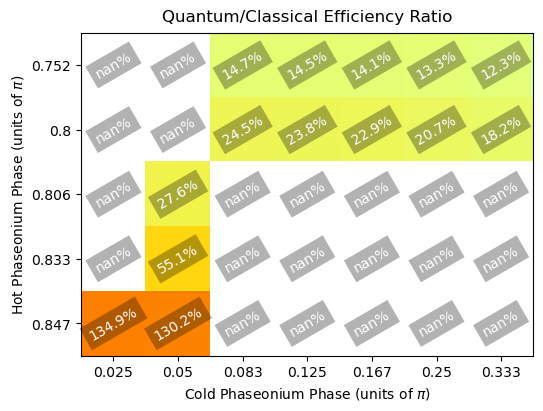

In [ ]:
filtered_df = filter_df(df_simulations, 
                        [("cavity1", "compressing_force"), 2.0],
                        [("cavity2", "compressing_force"), 2.0],
                        [("stroke_time", "isochore"), 1000000],
                        positive_efficiency=True,
                        )
pivot_table, names_table = make_pivot_table(filtered_df, "phaseonium_phi_hot", "phaseonium_phi_cold", f"gain")
fig, _ = plot_efficiency_scores(pivot_table, 
                       xlabel="Cold Phaseonium Phase (units of $\\pi$)",
                       ylabel="Hot Phaseonium Phase (units of $\\pi$)")

fig.savefig(ROOT.parent / "img/efficiency_scores_coherence.png")
fig.savefig(ROOT.parent / "img/efficiency_scores_coherence.pdf")

### Efficiency vs Thermalization Time

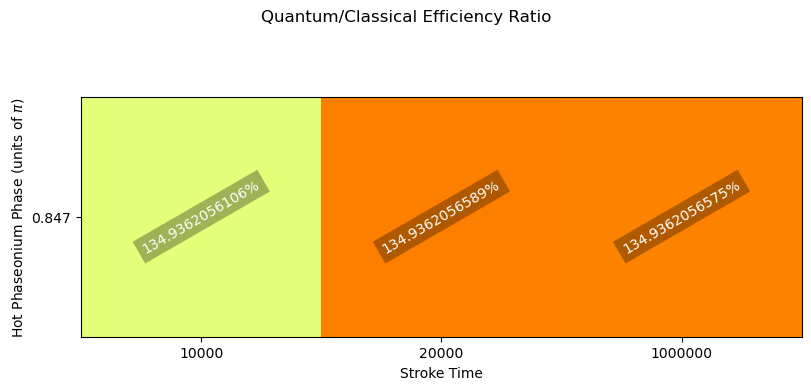

In [ ]:
filtered_df = filter_df(df_simulations, 
                        [("cavity1", "compressing_force"), 2.0],
                        [("cavity2", "compressing_force"), 2.0],
                        [("phaseonium", "phi_hot"), 1.18],
                        [("phaseonium", "phi_cold"), 40.0],
                        )
pivot_table, names_table = make_pivot_table(filtered_df, "phaseonium_phi_hot", "stroke_time_isochore", f"gain")
fig, _ = plot_efficiency_scores(pivot_table, precision=10, xlabel="Stroke Time", ylabel="Hot Phaseonium Phase (units of $\\pi$)")

fig.savefig(ROOT.parent / "img/efficiency_scores_thermalization.png")
fig.savefig(ROOT.parent / "img/efficiency_scores_thermalization.pdf")

### Mutual Information

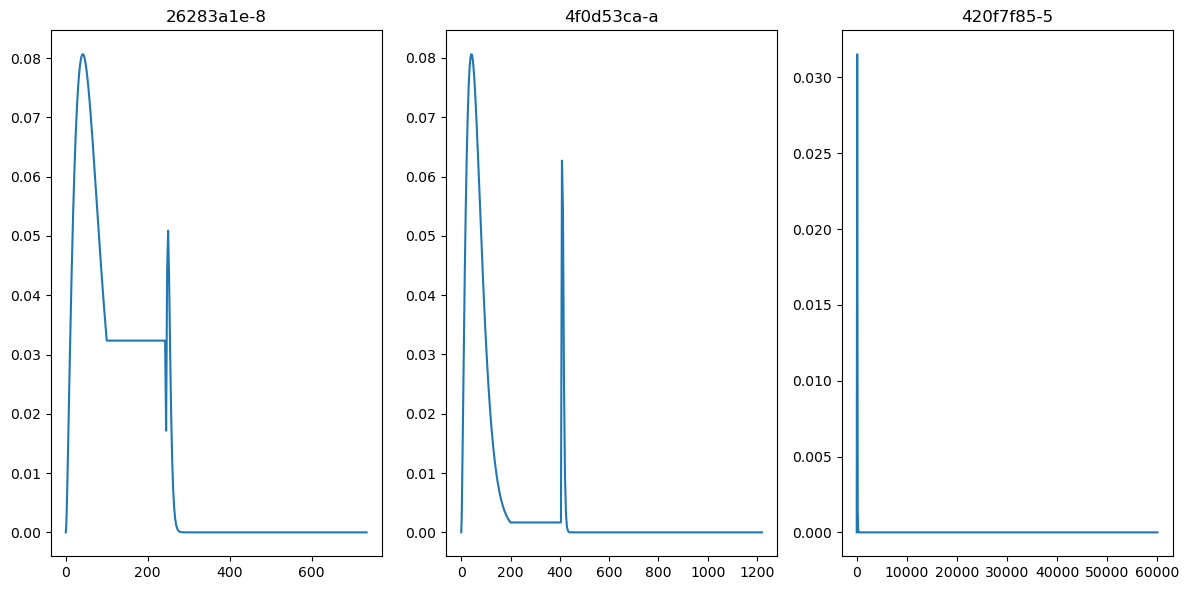

In [ ]:
figures_layout = filtered_df.pivot_table(
    index="phaseonium_phi_hot", columns="stroke_time_isochore", values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
fig, axs = plt.subplots(*figures_layout.shape, figsize=(12, 6), layout='tight')
if isinstance(axs, np.ndarray):
    axs = axs.flatten()

for i, row in enumerate(figures_layout.index):
    for j, col in enumerate(figures_layout.columns):
        f = ROOT / f"simulation_{figures_layout.iloc[i, j]}"
        if not f.exists():
            print(f"Cannot open {f}")
            continue

        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            mutinf = pickle.load(zipfile)["S"]["Mutual Information"]
        timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        
        ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)
        current_ax = i * len(figures_layout.columns) + j
        plot_observable(sampling_times, mutinf, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)


### Works

In [ ]:
with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
    work = pickle.load(zipfile)["S1"]["Work"]
i = 0
work['Classic']

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [ ]:
f1, f2 = forces
classical_work(f1[10], 0.1, 0.12)

np.float64(-0.0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (300,) + inhomogeneous part.

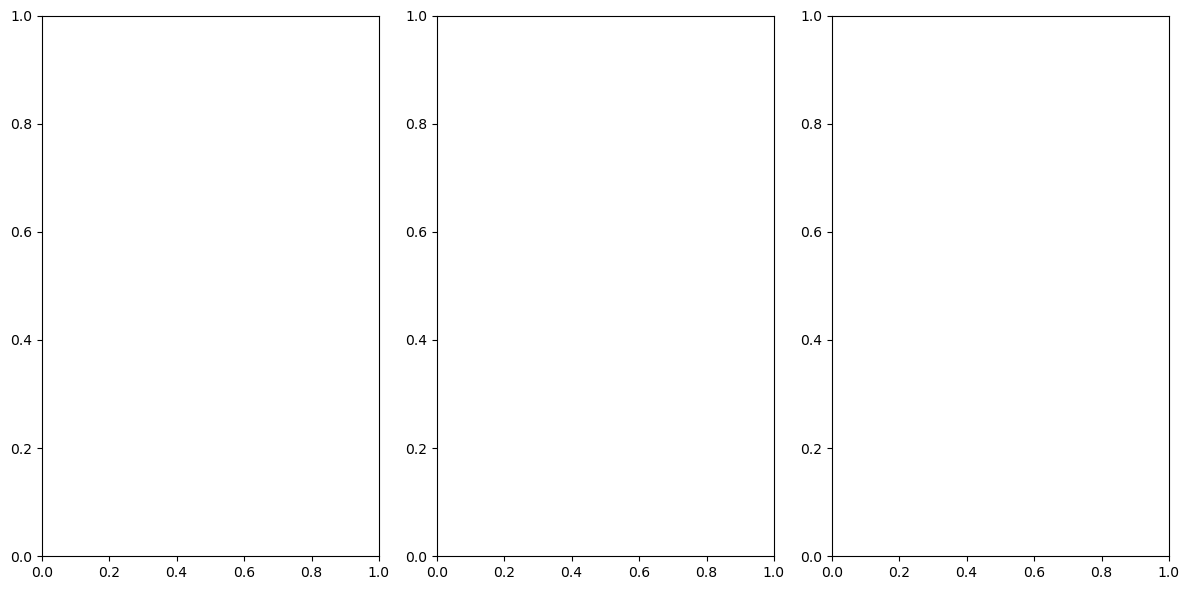

In [ ]:
figures_layout = filtered_df.pivot_table(
    index="phaseonium_phi_hot", columns="stroke_time_isochore", values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
fig, axs = plt.subplots(*figures_layout.shape, figsize=(12, 6), layout='tight')
if isinstance(axs, np.ndarray):
    axs = axs.flatten()

for i, row in enumerate(figures_layout.index):
    for j, col in enumerate(figures_layout.columns):
        f = ROOT / f"simulation_{figures_layout.iloc[i, j]}"
        if not f.exists():
            print(f"Cannot open {f}")
            continue

        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            work = pickle.load(zipfile)["S1"]["Work"]
        timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        
        work_al = np.array(work["Alicki"])
        work_pr = np.array(work["Pressure"])
        work_ext = work["Classic"]
        
        print(work_ext)

        ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)
        # current_ax = i * len(figures_layout.columns) + j
        # plot_observable(sampling_times, work_al, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        # plot_observable(sampling_times, work_pr, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        # # plot_observable(sampling_times, work_ext, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)


In [ ]:
ax.grid(alpha=0.2, linestyle='--')

ymax = max([
    max(work_al), max(works[0] + works[1]), max(works_ext[0] + works_ext[1])])
ymin = min([
    min(work_al), min(works[0] + works[1]), min(works_ext[0] + works_ext[1])])

plot_stroke_overlays(ax, ymin + 0.2*ymin, ymax + 0.2*ymax)

plot_observable(sampling_times[1:], np.real(work_al), ax=ax, label="Alicki's Work")
plot_observable(sampling_times[1:], works[0] + works[1], ax=ax, label="Classical Work")
# plot_observable(sampling_times[1:], works[0], ax=ax, label="Classical Work S1")
# plot_observable(sampling_times[1:], works[1], ax=ax, label="Classical Work S2")
plot_observable(sampling_times[1:], works_ext[0] + works_ext[1], ax=ax, label="Classical External Work")
# plot_observable(sampling_times[1:], works_ext[0], ax=ax, label="Classical External Work S1")
# plot_observable(sampling_times[1:], works_ext[1], ax=ax, label="Classical External Work S2")
ax.legend()

axbar.bar(["Alicki", "Classical", "External"], 
          [-total_work_al, -total_work, abs(total_work_ext)],
          color=["tab:blue", "tab:orange", "tab:green"])
axbar.set_title("Total Extracted Work")

plt.savefig(OUTPUT / "work.png")
plt.savefig(OUTPUT / "work.pdf")

plt.show()

In [ ]:
phi_hot = 1.6
phi_cold = 1.8
df_slice = filtered_df[(filtered_df.loc[:, "phaseonium_phi_cold"] == phi_cold) & (filtered_df.loc[:, "phaseonium_phi_hot"] == phi_hot)]
print(f"Carnot Efficiency is {df_slice.loc[:, 'output_Carnot'].values[0]}")
T_hot = classic_temp(T_HOT, OMEGA, np.pi / phi_hot)
T_cold = classic_temp(T_COLD, OMEGA, np.pi / phi_cold)
print(f"That's because hot temperature is {T_hot} and cold temperature is {T_cold}")
print(1 - T_cold / T_hot)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
pivot_table.loc[1.6, 1.8]
print(pivot_table.columns.name)
print(pivot_table.index.name)

KeyError: 1.8

In [ ]:
filtered_df[filtered_df[("phaseonium_phi_hot")]==1.8]

UndefVarError: UndefVarError: `filtered_df` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
ldf = filtered_df.loc["b5b25531-c"]
phi_hot= ldf["phaseonium_phi_hot"]
phi_cold = ldf["phaseonium_phi_cold"]
T_hot_cl = classic_temp(T_HOT, OMEGA, np.pi/phi_hot)
T_cold_cl = classic_temp(T_COLD, OMEGA, np.pi/phi_cold)
print(phi_hot)
print(phi_cold)
print(T_hot_cl)
print(T_cold_cl)
1-T_cold_cl/T_hot_cl

UndefVarError: UndefVarError: `filtered_df` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
classic_temp(2.5, OMEGA, np.pi/1.8)

np.float64(2.282339385386267)

## Efficiency with time
Now we reduce the thermalization time to see how the efficiency rateo changes

In [ ]:
# Fix parameters
CLASSICAL_ETA_DEF = "CNCA"  # Chambadal–Novikov–Curzon–Ahlborn or Carnot efficiency
c1_force = 2.0
c2_force = 2.0
phi_cold = 12
phi_hot = 1.25
filtered_df = df_simulations[
    (df_simulations.loc[:, ("cavity1", "compressing_force")] == c1_force) 
    & (df_simulations.loc[:, ("cavity2", "compressing_force")] == c2_force) 
    & (df_simulations.loc[:, ("phaseonium", "phi_cold")] == phi_cold) 
    & (df_simulations.loc[:, ("phaseonium", "phi_hot")] == phi_hot) 
    & (df_simulations.loc[:, ("output", "Carnot")] > 0)
]
filtered_df = filtered_df.reset_index()
filtered_df.columns = ['_'.join(col).strip() for col in filtered_df.columns.values]
filtered_df.loc[:, "gain"] = filtered_df["output_Efficiency"] / filtered_df[f"output_{CLASSICAL_ETA_DEF}"]
filtered_df.loc[:, "phaseonium_phi_hot"] = 1 / filtered_df.loc[:, "phaseonium_phi_hot"].values
filtered_df.loc[:, "phaseonium_phi_cold"] = 1 / filtered_df.loc[:, "phaseonium_phi_cold"].values
print(filtered_df.columns)
# Create a pivot table with X and Y as indices and Z as values
X = "phaseonium_phi_hot"
Y = "phaseonium_phi_cold"
Z = "gain"
pivot_table = filtered_df.pivot_table(index=X, columns=Y, values=Z)
names_table = filtered_df.pivot_table(index=X, columns=Y, values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")

# For a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.0%')
plt.title('Efficiency as a function of $\\phi_h$ and $\\phi_c$ (in $\\pi$ units)')
plt.tight_layout()
plt.show()